# Performing pyscenic on atlas to idenitify regulons

#### problems with pyscenic package and dependencies, therefore for all bash commands in this notebook, instead of running in my normal environment (env) run in environment called pyscenic2 (mamba activate pyscenic2) as this environmemnt has the correct package versions needed

* pyscenic installed on environemnt: https://pyscenic.readthedocs.io/en/latest/installation.html#docker-podman-and-singularity-apptainer-images 
* pyscenic pipline based on: https://htmlpreview.github.io/?https://github.com/aertslab/SCENICprotocol/blob/master/notebooks/PBMC10k_SCENIC-protocol-CLI.html
* GRN inference run using arboreto method: https://pyscenic.readthedocs.io/en/latest/faq.html#i-am-having-problems-with-dask

# Making environment for running bash commands


``` bash 
conda create -y -n pyscenic2 python=3.10
conda activate pyscenic2

# Install pySCENIC locally
mkdir /scratch/user/s4436039/software/
cd /scratch/user/s4436039/software/
git clone https://github.com/aertslab/pySCENIC.git
cd pySCENIC/
pip install -e . # this will install pySCENIC in editable mode

# Fix the dependencies
# also install loompy from the github becaues they fixed the issue with normalize.py 
# https://github.com/linnarsson-lab/loompy/issues/186
pip install git+https://www.github.com/linnarsson-lab/loompy.git
# use numpy==1.24.0 because of https://github.com/aertslab/pySCENIC/issues/584
pip install numpy==1.24.0

cd /scratch/user/s4436039/scdata/PySCENIC

#running pyscenic (step that was giving error in normal environment)
pyscenic aucell \
    DC1mreg_loom.loom \
    reg.csv \
    --output pyscenic_output.loom \
    --num_workers 1
```

# Load packages

In [1]:
#load packages I need
import os
import tools
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
#import pyscenic
#from pyscenic.aucell import aucell
import numpy as np

sc.logging.print_header()

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.0 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.12


# Import h5ad

In [2]:
#set current directory 
os.chdir('/scratch/user/s4436039/scdata/Python_Integration_Sep')
os.getcwd()

'/scratch/user/s4436039/scdata/Python_Integration_Sep'

In [3]:
# read in data
data = sc.read_h5ad('NRclean_clustered2.h5ad')

In [4]:
os.chdir('/scratch/user/s4436039/scdata/PySCENIC_Jan')
os.getcwd()

'/scratch/user/s4436039/scdata/PySCENIC_Jan'

## make loom file with expression data:

In [5]:
import loompy as lp
import numpy as np

In [9]:
# Save the path where you want loom file to save (current directory)
f_loom_path_DC = "DC_loom.loom"

In [10]:
row_attrs = { 
    "Gene": np.array(data.var.index) ,
}
col_attrs = { 
    "CellID":  np.array(data.obs.index) ,
    "nGene": np.array( np.sum(data.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(data.X.transpose() , axis=0)).flatten() ,
}

lp.create( f_loom_path_DC, data.X.transpose(), row_attrs, col_attrs )

## 1. GRN Inference - Run GRN pyscenic (20min)
* TF list (allTFs_hg38.txt) downloaded from https://resources.aertslab.org/cistarget/tf_lists/ 

### Run in bash (in pyscenic2 environment): 
``` bash
cd /scratch/user/s4436039/scdata/PySCENIC_Jan
arboreto_with_multiprocessing.py DC_loom.loom allTFs_hg38.txt --output adj.tsv --num_workers 1

In [6]:
!arboreto_with_multiprocessing.py DC_loom.loom allTFs_hg38.txt --output adj.tsv --num_workers 1

Loaded expression matrix of 12850 cells and 1268 genes in 0.5796971321105957 seconds...
Loaded 1892 TFs...
starting grnboost2 using 1 processes...
100%|███████████████████████████████████████| 1268/1268 [20:01<00:00,  1.06it/s]
Done in 1201.6172795295715 seconds.


In [3]:
# read in the adjacencies matrix
adjacencies = pd.read_csv("adj.tsv", index_col=False, sep='\t')

In [4]:
adjacencies.head()

,TF,target,importance
0,IRF8,CLEC9A,43.309302
1,REL,CCR7,25.238298
2,IRF8,CCR7,25.116283
3,IRF8,CLNK,22.595391
4,IRF4,LAMP3,22.553578


# 2. Cis-Regulatory Analysis - Regulon prediction 
* output: the regulons in reg.csv - list of adjacencies between a TF and its targets stored in MOTIFS_FNAME
* ranking database downloaded from: https://resources.aertslab.org/cistarget/databases/ details --> used Homo sapiens - hg38 - refseq_r80 - SCENIC+ databases - Gene based - hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather
* motif-to-TF database downloaded from: https://resources.aertslab.org/cistarget/motif2tf/

In [5]:
# set path to ranking database (.feather)
f_db_names = "/scratch/user/s4436039/scdata/PySCENIC/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather"

In [6]:
# set path to the motif-to-TF mapping database (this database links TF binding motifs to their corresponding TFs)
f_motif_path = "/scratch/user/s4436039/scdata/PySCENIC/motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl"

In [7]:
# set path to expression matrix
f_loom_path_scenic = "/scratch/user/s4436039/scdata/PySCENIC/DC1mreg_loom.loom"

### ctx step: cis-regulatory motif analysis 

In [15]:
!pyscenic ctx adj.tsv \
    {f_db_names} \
    --annotations_fname {f_motif_path} \
    --expression_mtx_fname {f_loom_path_scenic} \
    --output reg.csv \
    --mask_dropouts \
    --num_workers 20


2024-12-18 12:43:35,964 - pyscenic.cli.pyscenic - INFO - Creating modules.

2024-12-18 12:43:35,994 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2024-12-18 12:43:36,638 - pyscenic.utils - INFO - Calculating Pearson correlations.

2024-12-18 12:43:36,644 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2024-12-18 12:43:40,039 - pyscenic.utils - INFO - Creating modules.

2024-12-18 12:43:41,942 - pyscenic.cli.pyscenic - IN

# Regulon Activity/Cellular enrichment (aucell)
* identifies the activity of these regulons at the single cell level by calculating an enrichment score

### First checking most cells have a substantial fraction of expressed/detected genes in the calculation of the AUC (as done in tutorial)

In [13]:
nGenesDetectedPerCellbefore = np.sum(data_DC1mreg.X>0, axis=1)
nGenesDetectedPerCell = pd.Series(nGenesDetectedPerCellbefore)
percentiles = nGenesDetectedPerCell.quantile([0.01, 0.05, 0.10, 0.50, 1])
print(percentiles)

0.01     31.0
0.05     52.0
0.10     71.0
0.50    160.0
1.00    485.0
dtype: float64


/scratch/temp/12001575/ipykernel_931721/3887338572.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')


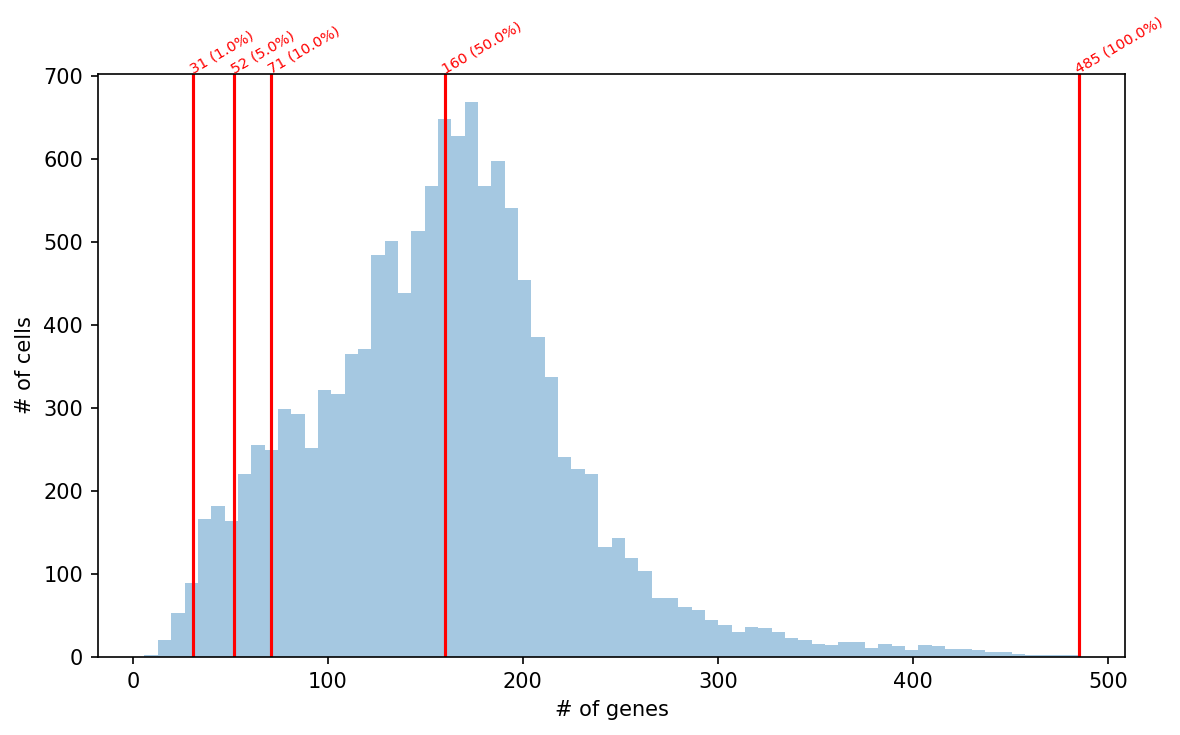

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0, ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small', rotation_mode='anchor')
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

* default auc_threshold is 0.05 (5%) which here would include 52 genes 

## Run AUC (area under the curve for enrichment algorithm to calculate regulon activity scores):

### Run in bash:

``` bash
pyscenic aucell \
    DC1mreg_loom.loom \
    reg.csv \
    --output pyscenic_output.loom \
    --num_workers 1

## Visualise SCENIC's AUC matrix: